In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

In [2]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

In [3]:
omega_index = 1 # while we debug, we confine our attention to just one value
onh2 = spectra.omega_nu[omega_index]
onh2_str = spectra.omnu_strings[omega_index]

In [4]:
k_massless_list = []
z_massless_list = []
p_massless_list = []
s12_massless_list = []

k_massive_list = []
z_massive_list = []
p_massive_list = []
s12_massive_list = []

for index, row in spectra.cosm.iterrows():
    if index > 7:
        # I don't yet understand how to implement the last model; skip
        continue
    # This is just a sanity test:
    # The model values don't change through a sort of reverse-engineering
    row["ombh2"] = row["OmB"] * row["h"] ** 2
    OmCDM = row["OmM"] - row["OmB"]
    row["omch2"] = OmCDM * row["h"] ** 2
    
    # Sanity check over
    z_in = spectra.parse_redshifts(index)
    k, z, p, s12 = spectra.kzps(row, onh2, massive_neutrinos=False,
                       zs=z_in)
    k_massless_list.append(k)
    z_massless_list.append(z)
    p_massless_list.append(p)
    s12_massless_list.append(s12)
    
    k, z, p, s12 = spectra.kzps(row, onh2, massive_neutrinos=True,
                       zs=z_in)
    k_massive_list.append(k)
    z_massive_list.append(z)
    p_massive_list.append(p)
    s12_massive_list.append(s12)

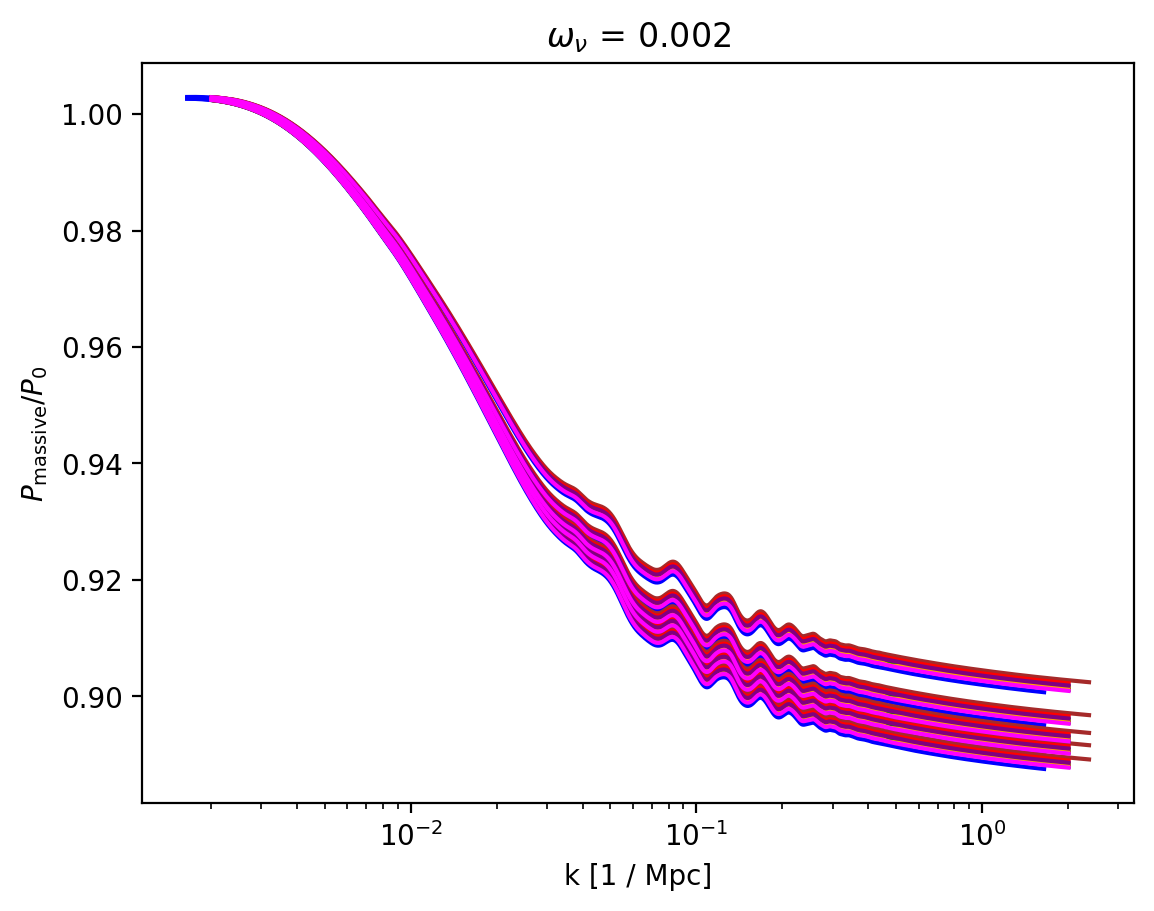

In [5]:
for i in range(len(k_massive_list)):
    h = spectra.cosm.loc[i]["h"]
    for j in range(5):
        plt.plot(k_massless_list[i] * h,
                 p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i) + ", no renormalizing, z=" + \
                 str(spectra.parse_redshifts(index)[j]), c=spectra.colors[i],
                 linestyle=spectra.styles[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(onh2))

Redshift is 0.0


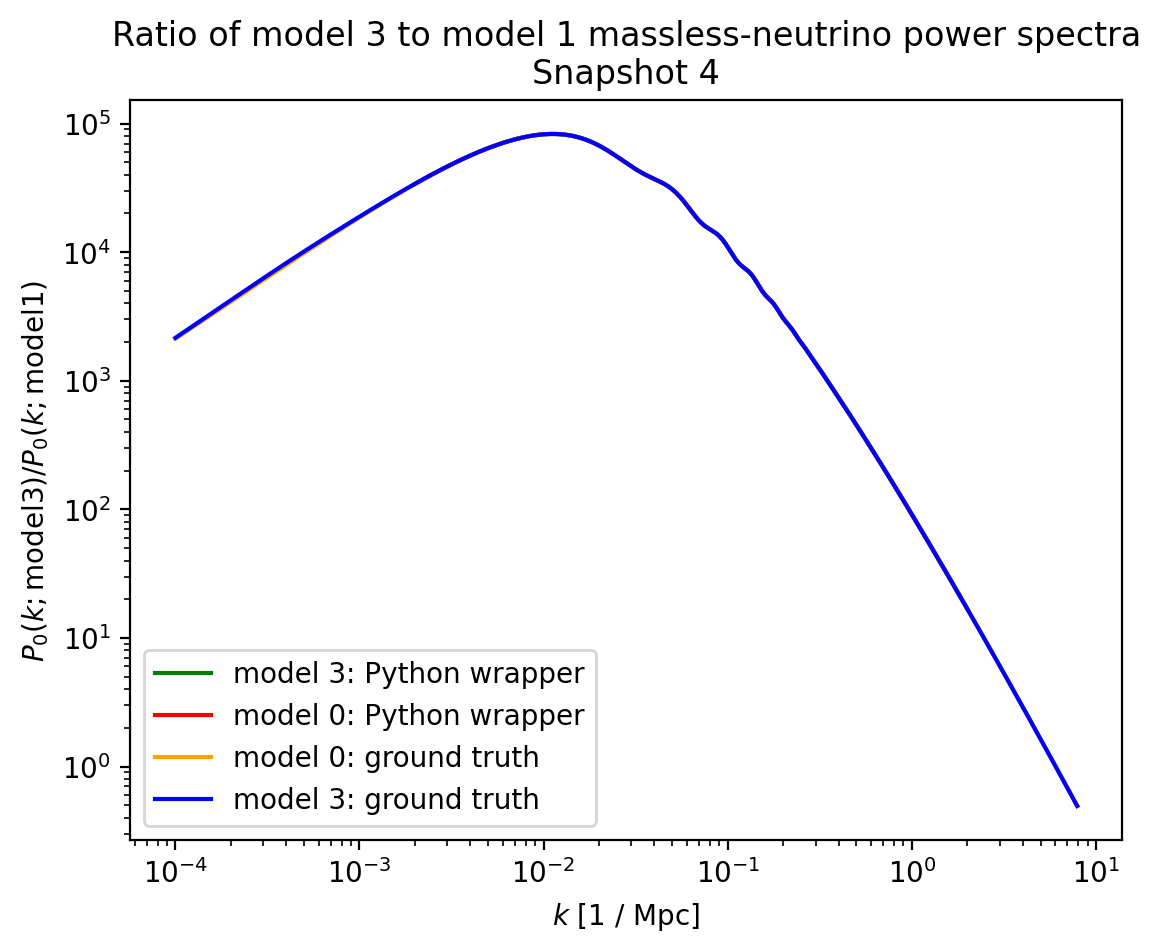

In [6]:
i = 3
z_index = 0
snap_index = 4 - z_index

print("Redshift is", z_massless_list[0][z_index])

baseline_h = spectra.cosm.loc[0]["h"]
baseline_k = k_massless_list[0] * baseline_h
baseline_p = p_massless_list[0][z_index] / baseline_h ** 3

this_h = spectra.cosm.loc[i]["h"]
this_k = k_massless_list[i] * this_h
this_p = p_massless_list[i][z_index] / this_h ** 3

truncated_k, truncated_p, aligned_p = \
    spectra.truncator(baseline_k, baseline_p, this_k,
    this_p, interpolation=this_h != baseline_h)

baseline_k_true = spectra.powernu[onh2_str][0][snap_index]["k"]
baseline_p_true = spectra.powernu[onh2_str][0][snap_index]["P_no"]
this_k_true = spectra.powernu[onh2_str][i][snap_index]["k"]
this_p_true = spectra.powernu[onh2_str][i][snap_index]["P_no"]

plt.plot(truncated_k, aligned_p, c="green", label="model 3: Python wrapper")
plt.plot(truncated_k, truncated_p, c="red", label="model 0: Python wrapper")
plt.plot(baseline_k_true, baseline_p_true, c="orange",
         label="model 0: ground truth")
plt.plot(this_k_true, this_p_true, c="blue", label="model 3: ground truth")
plt.title("Ratio of model 3 to model 1 massless-neutrino power spectra" + \
         "\nSnapshot " + str(snap_index))
plt.ylabel(r"$P_0 (k; \mathrm{model 3}) / P_0 (k; \mathrm{model 1})$")
plt.xlabel(r"$k$ [1 / Mpc]")
plt.xscale("log")
plt.yscale("log")
plt.legend()

Redshift is 0.0


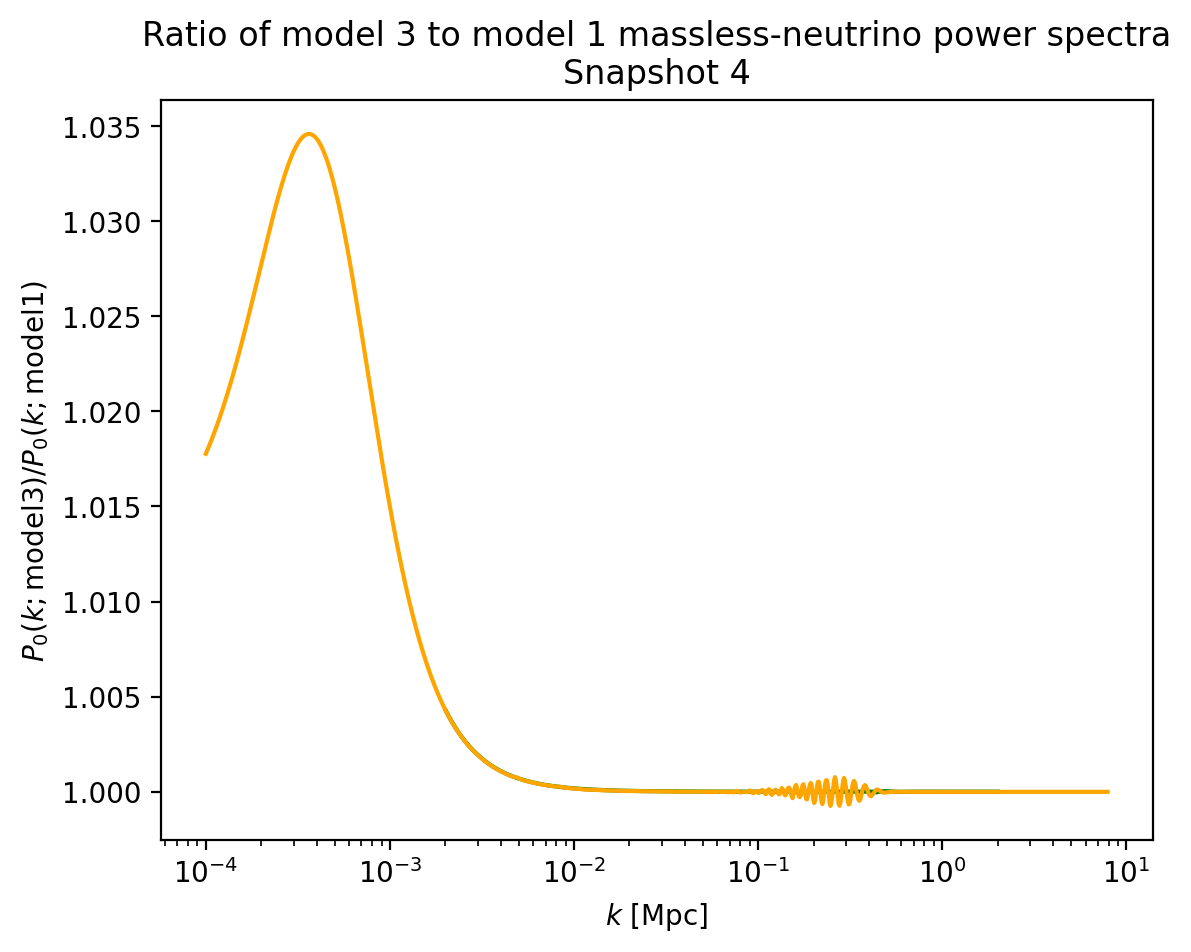

In [7]:
i = 3
z_index = 0
snap_index = 4 - z_index

print("Redshift is", z_massless_list[0][z_index])

baseline_h = spectra.cosm.loc[0]["h"]
baseline_k = k_massless_list[0] * baseline_h
baseline_p = p_massless_list[0][z_index] / baseline_h ** 3

this_h = spectra.cosm.loc[i]["h"]
this_k = k_massless_list[i] * this_h
this_p = p_massless_list[i][z_index] / this_h ** 3

truncated_k, truncated_p, aligned_p = \
    spectra.truncator(baseline_k, baseline_p, this_k,
    this_p, interpolation=this_h != baseline_h)

plt.plot(truncated_k, aligned_p / truncated_p, c="green",
        label="Python wrapper")
#! I don't think we need to do interpolation, since they agree on h.
    # But in case anything weird happens I want to keep this in mind.
plt.plot(spectra.powernu[onh2_str][i][snap_index]["k"],
         spectra.powernu[onh2_str][i][snap_index]["P_no"] / \
         spectra.powernu[onh2_str][0][snap_index]["P_no"],
         c="orange", label="ground truth")
plt.title("Ratio of model 3 to model 1 massless-neutrino power spectra" + \
         "\nSnapshot " + str(snap_index))
plt.ylabel(r"$P_0 (k; \mathrm{model 3}) / P_0 (k; \mathrm{model 1})$")
plt.xlabel(r"$k$ [Mpc]")
plt.xscale("log")

In [14]:
len(spectra.powernu["0.002"])

9

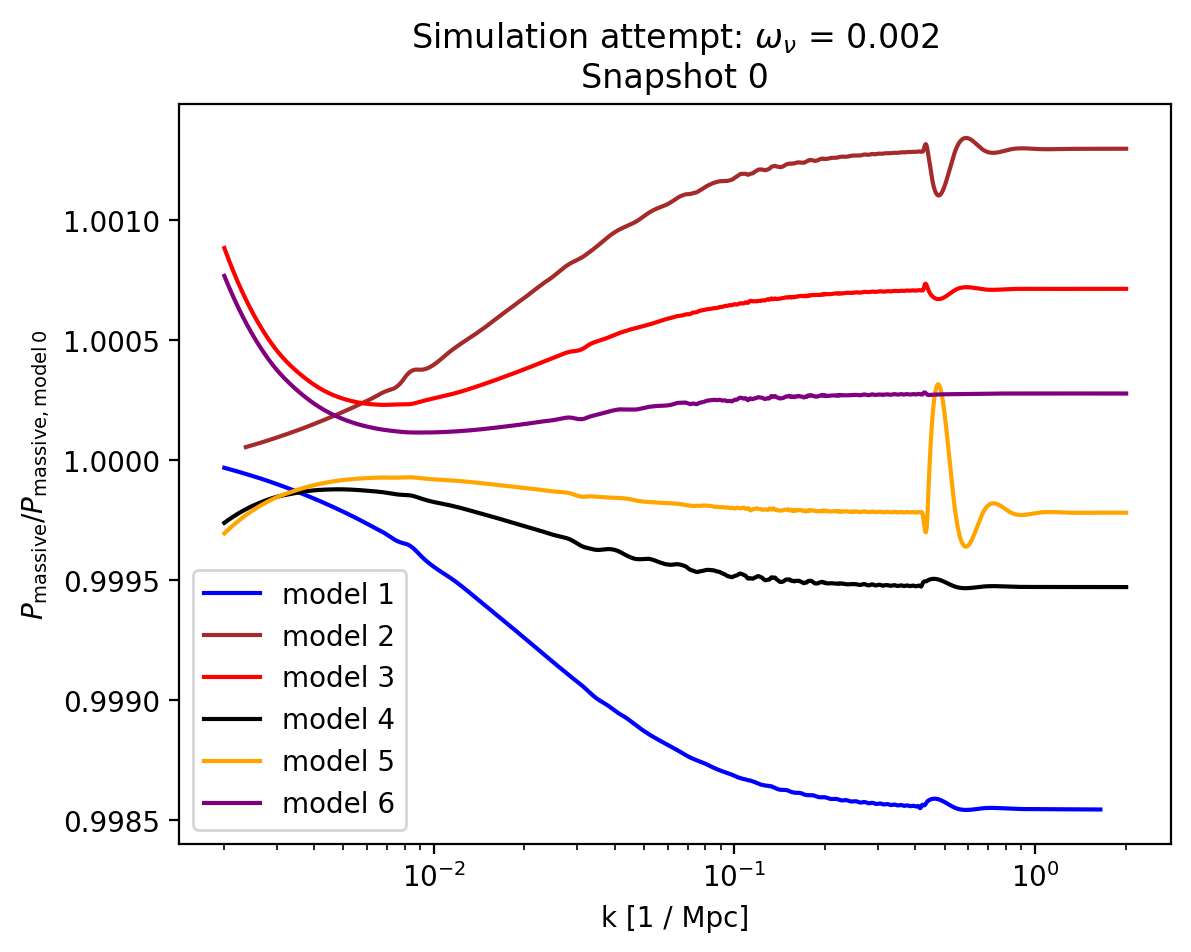

In [8]:
spectra.model_ratios(
    k_massive_list, p_massive_list, 0, "massive",
    r"Simulation attempt: $\omega_\nu$ = " + str(onh2) + "\n" + \
    "Snapshot 0")

model 1


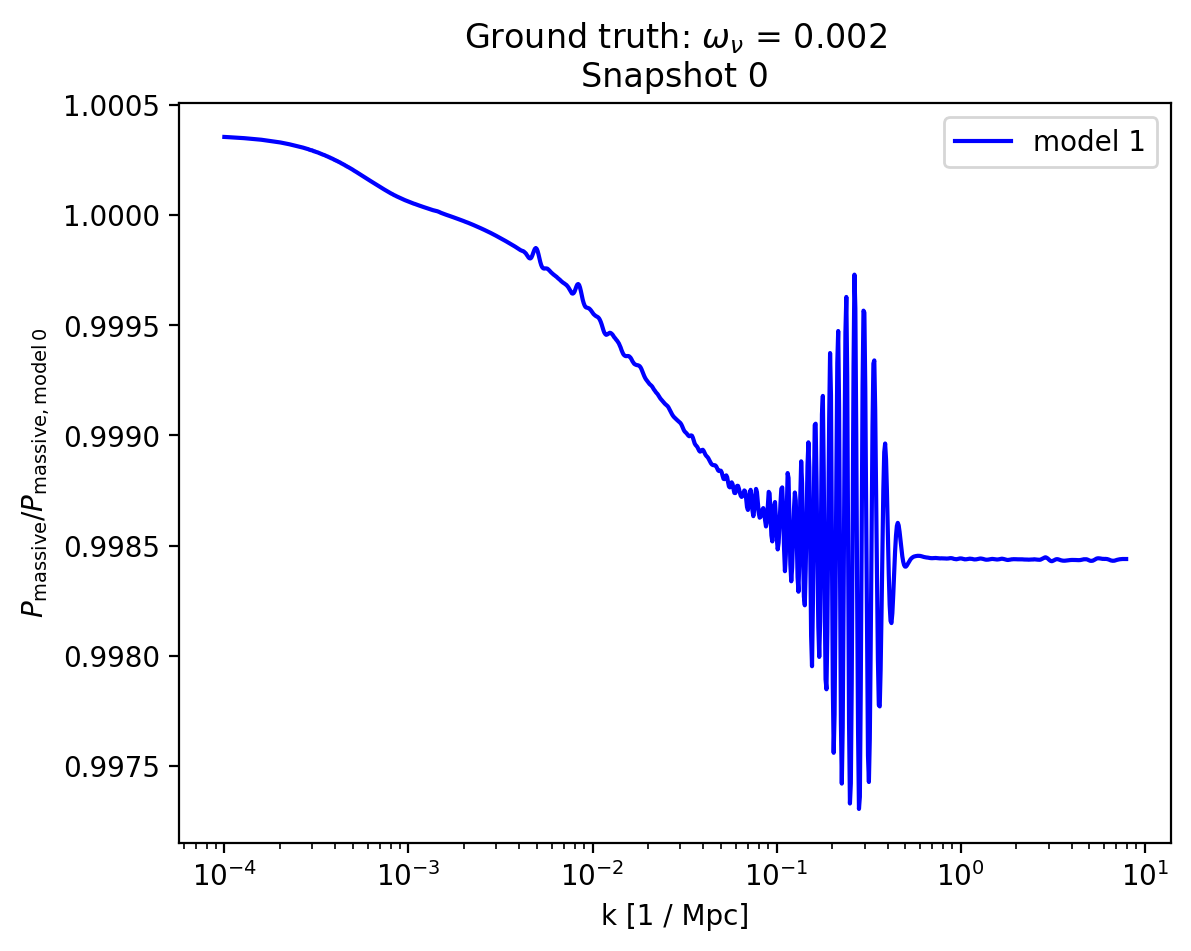

In [9]:
# What was this supposed to look like?
spectra.model_ratios_true(0, onh2_str, massive=True)

In [10]:
spectra.model_ratios(k_massive_list, p_massive_list, 4, "massive")

TypeError: model_ratios() missing 1 required positional argument: 'title'

In [ ]:
spectra.model_ratios_true(4, massive=True)

In [ ]:
spectra.model_ratios(k_massless_list, p_massless_list, 0, "massless")

In [ ]:
spectra.model_ratios_true(0, massive=False)

In [ ]:
spectra.model_ratios(k_massless_list, p_massless_list, 4, "massless")

In [ ]:
spectra.model_ratios_true(4, massive=False)

In [ ]:
for i in range(0, 3):
    h = spectra.cosm.loc[i]["h"]
    j = 4 # just look at z=0 before moving on
    plt.plot(k_massless_list[i] * h,
             p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i), c=spectra.colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(onh2) + "; $z=0$")
    plt.legend()

Currently I am not re-normalizing the amplitude of one model based on its counterpart. At least, I *think* I'm not doing that, but I'm really quite unsure

In [ ]:
baseline = spectra[onh2_str][0][0]
baseline_max = spectra[onh2_str][0][4] # why is this "max"?

In [ ]:
# Let's just look at model 0 for the initial comparisons
i = 0
# Let's just look at redshift 0 for the initial comparisons
j = 4

h = spectra.cosm.loc[i]["h"]
plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
             label="my result for z=" + str(z_massive_list[i][j]),
             c=spectra.colors[i])
j = 0 # This will correspond to z=2 for the model0 case.
plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
             label="my result for z="  + str(z_massive_list[i][j]), c="black")
plt.plot(baseline["k"], baseline["ratio"], label="powernu.tar snapshot 0")
plt.plot(baseline_max["k"], baseline_max["ratio"],
         label="powernu.tar snapshot 4")
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + str(onh2) + "; model 0")
plt.legend()

We've now made absolutely certain that my lines here should overlap with Ariel's. What went wrong?

In [ ]:
h = spectra.cosm.loc[i]["h"]
j = 4
plt.plot(k_massless_list[i] * h, p_massless_list[i][j],
             label="my no-neut", c=spectra.colors[i])
plt.plot(k_massless_list[i] * h, p_massive_list[i][j],
             label="my neuts", c="black")
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P(k)$ [?]")
plt.title(r"$\omega_\nu$ = " + str(onh2) + "; model 0")
plt.legend()